In [14]:
token="T66OchuLddDzcXG3P3FMsyS4cI981IXspNDAj8hwCNh_"
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_cloud",
  overwrite=True,
  instance=""
)

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT, UnitaryGate

def create_qpe_circuit(num_ancilla: int,
                       U_gate: UnitaryGate,
                       state_prep: QuantumCircuit) -> QuantumCircuit:

    n_target = state_prep.num_qubits
    U_mat    = U_gate.to_matrix()

    qc = QuantumCircuit(num_ancilla + n_target, num_ancilla)
    qc.h(range(num_ancilla))
    qc.compose(state_prep,
               qubits=list(range(num_ancilla,
                                 num_ancilla + n_target)),
               inplace=True)

    for j in range(num_ancilla):
        mat_pow = np.linalg.matrix_power(U_mat, 2**j)
        cU = UnitaryGate(mat_pow).control()
        qc.append(cU,
                  [j] + list(range(num_ancilla,
                                   num_ancilla + n_target)))

    qc.compose(QFT(num_ancilla, do_swaps=True).inverse(),
               range(num_ancilla), inplace=True)

    qc.measure(range(num_ancilla), range(num_ancilla))
    return qc
    
def make_U_phi(phi: float) -> UnitaryGate:
    phase = np.exp(2j * math.pi * phi)
    return UnitaryGate(np.array([[1,0],[0,phase]]), label="Uφ")

def run_qpe_weighted_error(num_ancilla: int,
                           U_gate: UnitaryGate,
                           state_prep: QuantumCircuit,
                           true_phi: float,
                           noise_model=None,
                           shots: int = 8192):

    qc       = create_qpe_circuit(num_ancilla, U_gate, state_prep)
    backend  = AerSimulator(noise_model=noise_model,
                            basis_gates=noise_model.basis_gates
                                         if noise_model else None)
    compiled = transpile(qc, backend)
    counts   = backend.run(compiled, shots=shots).result().get_counts()

    t = num_ancilla
    w_err = sum(
        abs(int(bitstr, 2) / (2**t) - true_phi) * c
        for bitstr, c in counts.items()
    ) / shots
    return w_err, counts

C:\Users\yoonh\AppData\Local\Temp\ipykernel_9584\1639960316.py:32: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(num_ancilla, do_swaps=True).inverse(),


depolarizing       p=0.01  →  ⟨|Δφ|⟩=1.078e-01
depolarizing       p=0.02  →  ⟨|Δφ|⟩=1.576e-01


C:\Users\yoonh\AppData\Local\Temp\ipykernel_9584\1639960316.py:32: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(num_ancilla, do_swaps=True).inverse(),


depolarizing       p=0.03  →  ⟨|Δφ|⟩=1.893e-01
depolarizing       p=0.04  →  ⟨|Δφ|⟩=2.140e-01
depolarizing       p=0.05  →  ⟨|Δφ|⟩=2.224e-01
depolarizing       p=0.06  →  ⟨|Δφ|⟩=2.314e-01
depolarizing       p=0.07  →  ⟨|Δφ|⟩=2.385e-01
depolarizing       p=0.08  →  ⟨|Δφ|⟩=2.371e-01
depolarizing       p=0.09  →  ⟨|Δφ|⟩=2.474e-01
depolarizing       p=0.10  →  ⟨|Δφ|⟩=2.482e-01
phase_damping      p=0.01  →  ⟨|Δφ|⟩=4.319e-02
phase_damping      p=0.02  →  ⟨|Δφ|⟩=6.958e-02
phase_damping      p=0.03  →  ⟨|Δφ|⟩=8.370e-02
phase_damping      p=0.04  →  ⟨|Δφ|⟩=1.069e-01
phase_damping      p=0.05  →  ⟨|Δφ|⟩=1.210e-01
phase_damping      p=0.06  →  ⟨|Δφ|⟩=1.287e-01
phase_damping      p=0.07  →  ⟨|Δφ|⟩=1.446e-01
phase_damping      p=0.08  →  ⟨|Δφ|⟩=1.550e-01
phase_damping      p=0.09  →  ⟨|Δφ|⟩=1.664e-01
phase_damping      p=0.10  →  ⟨|Δφ|⟩=1.710e-01
amplitude_damping  p=0.01  →  ⟨|Δφ|⟩=5.599e-02
amplitude_damping  p=0.02  →  ⟨|Δφ|⟩=8.370e-02
amplitude_damping  p=0.03  →  ⟨|Δφ|⟩=1.092e-01
amplitude_dam

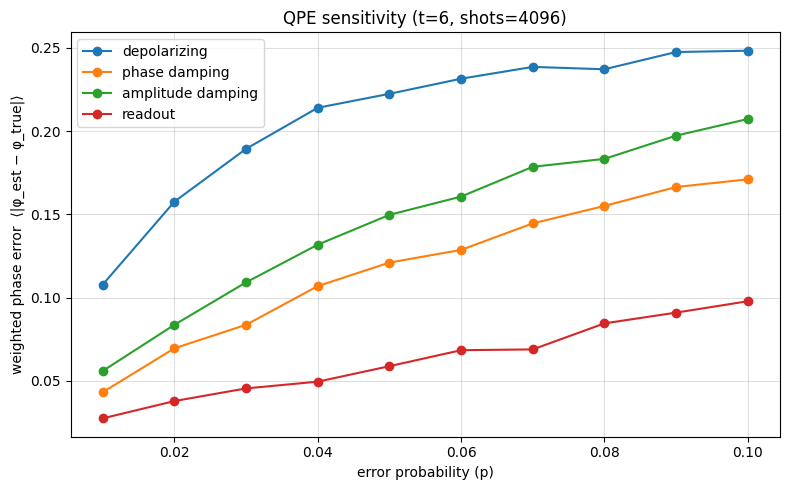

In [ ]:
import numpy as np, math, matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate, QFT
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel, depolarizing_error,
    phase_damping_error, amplitude_damping_error, ReadoutError
)

def make_noise_model(kind: str, p: float) -> NoiseModel:
    nm = NoiseModel()
    if kind == "depolarizing":
        nm.add_all_qubit_quantum_error(depolarizing_error(p, 1),
                                       ['x','y','z','h','sx','u'])
        nm.add_all_qubit_quantum_error(depolarizing_error(p, 2),
                                       ['cx'])
    elif kind == "phase_damping":
        pd = phase_damping_error(p)
        nm.add_all_qubit_quantum_error(pd,  ['x','y','z','h','sx','u'])
    elif kind == "amplitude_damping":
        ad = amplitude_damping_error(p)
        nm.add_all_qubit_quantum_error(ad,  ['x','y','z','h','sx','u'])
    elif kind == "readout":
        ro = ReadoutError([[1-p, p],
                           [p, 1-p]])
        nm.add_all_qubit_readout_error(ro)
    else:
        raise ValueError(f"Unknown noise type: {kind}")
    return nm


phi         = 3/7
t_ancilla   = 6
SHOTS       = 4096
U_gate      = make_U_phi(phi)
state_prep  = QuantumCircuit(1); state_prep.x(0)

error_rates = np.linspace(0.01, 0.10, 10)  
noise_kinds = ["depolarizing",
               "phase_damping", "amplitude_damping",
               "readout"]


results = {k: [] for k in noise_kinds}
for kind in noise_kinds:
    for p in error_rates:
        nm = make_noise_model(kind, p)
        w_err, _ = run_qpe_weighted_error(t_ancilla,
                                          U_gate,
                                          state_prep,
                                          phi,
                                          noise_model=nm,
                                          shots=SHOTS)
        results[kind].append(w_err)
        print(f"{kind:18s} p={p:4.2f}  →  ⟨|Δφ|⟩={w_err:8.3e}")


plt.figure(figsize=(8,5))
for kind, errs in results.items():
    plt.plot(error_rates, errs, marker='o', label=kind.replace('_',' '))
plt.xlabel("error probability (p)")
plt.ylabel("weighted phase error  ⟨|φ_est − φ_true|⟩")
plt.title(f"QPE sensitivity (t={t_ancilla}, shots={SHOTS})")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\yoonh\AppData\Local\Temp\ipykernel_9584\1639960316.py:32: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(num_ancilla, do_swaps=True).inverse(),


depolarizing       p=0.01  →  ⟨|Δφ|⟩=1.129e-01
depolarizing       p=0.02  →  ⟨|Δφ|⟩=1.617e-01
depolarizing       p=0.03  →  ⟨|Δφ|⟩=1.947e-01
depolarizing       p=0.04  →  ⟨|Δφ|⟩=2.134e-01
depolarizing       p=0.05  →  ⟨|Δφ|⟩=2.252e-01
depolarizing       p=0.06  →  ⟨|Δφ|⟩=2.353e-01
depolarizing       p=0.07  →  ⟨|Δφ|⟩=2.362e-01
depolarizing       p=0.08  →  ⟨|Δφ|⟩=2.409e-01
depolarizing       p=0.09  →  ⟨|Δφ|⟩=2.462e-01
depolarizing       p=0.10  →  ⟨|Δφ|⟩=2.467e-01
phase_damping      p=0.01  →  ⟨|Δφ|⟩=4.269e-02
phase_damping      p=0.02  →  ⟨|Δφ|⟩=6.432e-02
phase_damping      p=0.03  →  ⟨|Δφ|⟩=8.636e-02
phase_damping      p=0.04  →  ⟨|Δφ|⟩=1.004e-01
phase_damping      p=0.05  →  ⟨|Δφ|⟩=1.208e-01
phase_damping      p=0.06  →  ⟨|Δφ|⟩=1.285e-01
phase_damping      p=0.07  →  ⟨|Δφ|⟩=1.506e-01
phase_damping      p=0.08  →  ⟨|Δφ|⟩=1.570e-01
phase_damping      p=0.09  →  ⟨|Δφ|⟩=1.689e-01
phase_damping      p=0.10  →  ⟨|Δφ|⟩=1.729e-01
amplitude_damping  p=0.01  →  ⟨|Δφ|⟩=5.852e-02
amplitude_dam

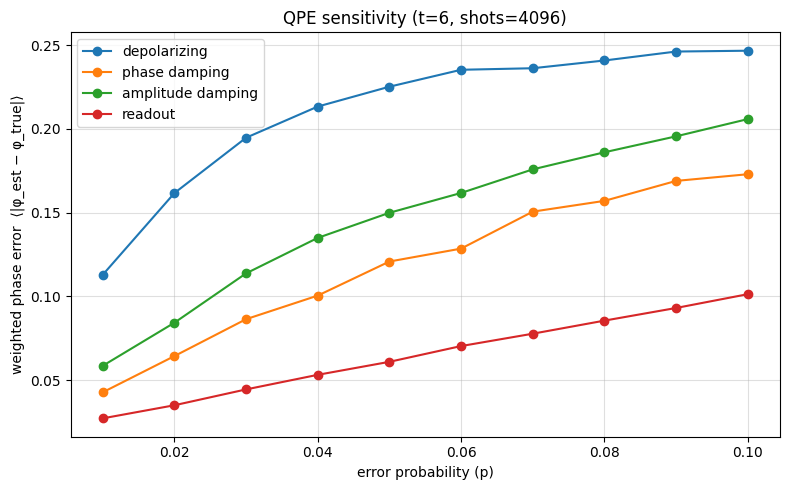

In [ ]:
import numpy as np, math, matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate, QFT
from qiskit_aer import AerSimulator

phi         = 3/7
t_ancilla   = 6
SHOTS       = 4096
U_gate      = make_U_phi(phi)
state_prep  = QuantumCircuit(1); state_prep.x(0)

error_rates = np.linspace(0.01, 0.10, 10)     
noise_kinds = ["depolarizing",
               "phase_damping", "amplitude_damping",
               "readout"]

results = {k: [] for k in noise_kinds}
for kind in noise_kinds:
    for p in error_rates:
        nm = make_noise_model(kind, p)
        w_err, _ = run_qpe_weighted_error(t_ancilla,
                                          U_gate,
                                          state_prep,
                                          phi,
                                          noise_model=nm,
                                          shots=SHOTS)
        results[kind].append(w_err)
        print(f"{kind:18s} p={p:4.2f}  →  ⟨|Δφ|⟩={w_err:8.3e}")

plt.figure(figsize=(8,5))
for kind, errs in results.items():
    plt.plot(error_rates, errs, marker='o', label=kind.replace('_',' '))
plt.xlabel("error probability (p)")
plt.ylabel("weighted phase error  ⟨|φ_est − φ_true|⟩")
plt.title(f"QPE sensitivity (t={t_ancilla}, shots={SHOTS})")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\yoonh\AppData\Local\Temp\ipykernel_9584\1639960316.py:32: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(num_ancilla, do_swaps=True).inverse(),


depolarizing       p=0.01  →  ⟨|Δφ|⟩=1.080e-01
depolarizing       p=0.02  →  ⟨|Δφ|⟩=1.599e-01
depolarizing       p=0.03  →  ⟨|Δφ|⟩=1.878e-01
depolarizing       p=0.04  →  ⟨|Δφ|⟩=2.088e-01
depolarizing       p=0.05  →  ⟨|Δφ|⟩=2.240e-01
depolarizing       p=0.06  →  ⟨|Δφ|⟩=2.321e-01
depolarizing       p=0.07  →  ⟨|Δφ|⟩=2.437e-01
depolarizing       p=0.08  →  ⟨|Δφ|⟩=2.450e-01
depolarizing       p=0.09  →  ⟨|Δφ|⟩=2.460e-01
depolarizing       p=0.10  →  ⟨|Δφ|⟩=2.479e-01
phase_damping      p=0.01  →  ⟨|Δφ|⟩=4.440e-02
phase_damping      p=0.02  →  ⟨|Δφ|⟩=6.629e-02
phase_damping      p=0.03  →  ⟨|Δφ|⟩=8.550e-02
phase_damping      p=0.04  →  ⟨|Δφ|⟩=1.068e-01
phase_damping      p=0.05  →  ⟨|Δφ|⟩=1.166e-01
phase_damping      p=0.06  →  ⟨|Δφ|⟩=1.358e-01
phase_damping      p=0.07  →  ⟨|Δφ|⟩=1.460e-01
phase_damping      p=0.08  →  ⟨|Δφ|⟩=1.553e-01
phase_damping      p=0.09  →  ⟨|Δφ|⟩=1.674e-01
phase_damping      p=0.10  →  ⟨|Δφ|⟩=1.768e-01
amplitude_damping  p=0.01  →  ⟨|Δφ|⟩=5.605e-02
amplitude_dam

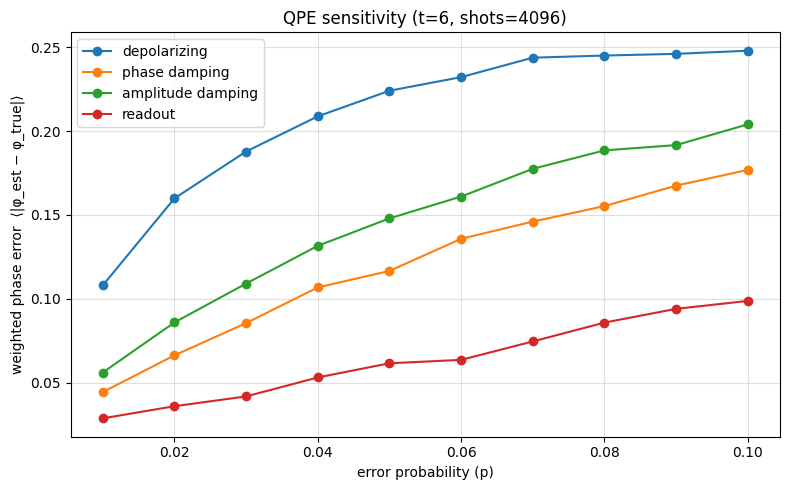

In [ ]:
import numpy as np, math, matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate, QFT
from qiskit_aer import AerSimulator

t_ancilla   = 6
SHOTS       = 4096
U_gate      = make_U_phi(phi)
state_prep  = QuantumCircuit(1); state_prep.x(0)

error_rates = np.linspace(0.01, 0.10, 10)     
noise_kinds = ["depolarizing",
               "phase_damping", "amplitude_damping",
               "readout"]


results = {k: [] for k in noise_kinds}
for kind in noise_kinds:
    for p in error_rates:
        nm = make_noise_model(kind, p)
        w_err, _ = run_qpe_weighted_error(t_ancilla,
                                          U_gate,
                                          state_prep,
                                          phi,
                                          noise_model=nm,
                                          shots=SHOTS)
        results[kind].append(w_err)
        print(f"{kind:18s} p={p:4.2f}  →  ⟨|Δφ|⟩={w_err:8.3e}")

plt.figure(figsize=(8,5))
for kind, errs in results.items():
    plt.plot(error_rates, errs, marker='o', label=kind.replace('_',' '))
plt.xlabel("error probability (p)")
plt.ylabel("weighted phase error  ⟨|φ_est − φ_true|⟩")
plt.title(f"QPE sensitivity (t={t_ancilla}, shots={SHOTS})")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


Fake backend = fake_melbourne  (15 qubits)


C:\Users\yoonh\AppData\Local\Temp\ipykernel_9584\1639960316.py:32: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(num_ancilla, do_swaps=True).inverse(),


⇒ weighted error = 2.227e-01


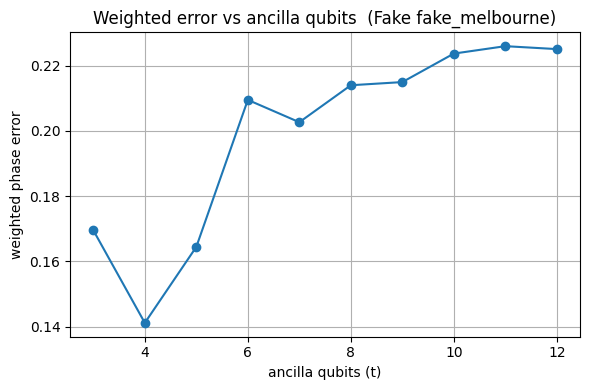

In [5]:
import inspect, numpy as np, matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, noise
from qiskit_ibm_runtime import fake_provider


phi, t_ancilla, n_target, SHOTS = 3/7, 12, 1, 4096
qubits_req = t_ancilla + n_target

def pick_fake_backend(min_qubits: int):
    candidates = []
    for name, cls in inspect.getmembers(fake_provider, inspect.isclass):
        if not (name.startswith("Fake") and name.endswith("V2")):
            continue
        try:
            backend = cls() 
        except Exception:
            continue
        if hasattr(backend, "num_qubits") and backend.num_qubits >= min_qubits:
            candidates.append((backend.num_qubits, backend))
    if not candidates:
        raise RuntimeError(f"{min_qubits}-qubit 이상 지원하는 fake backend가 없습니다.")

    return sorted(candidates, key=lambda x: x[0])[0][1]
    
fake_backend = pick_fake_backend(qubits_req)
print(f"Fake backend = {fake_backend.name}  ({fake_backend.num_qubits} qubits)")

backend_noise = noise.NoiseModel.from_backend(fake_backend)
simulator = AerSimulator(
    noise_model = backend_noise,
    basis_gates = backend_noise.basis_gates,
    coupling_map= fake_backend.configuration().coupling_map
)

U_gate, state_prep = make_U_phi(phi), QuantumCircuit(1); state_prep.x(0)
qpe_circ = create_qpe_circuit(t_ancilla, U_gate, state_prep)

t_qc = transpile(
    qpe_circ,
    target            = fake_backend.target, 
    optimization_level= 3,
    seed_transpiler   = 42
)

result = simulator.run(t_qc, shots=SHOTS).result()
counts = result.get_counts()
w_err  = sum(abs(int(b,2)/(2**t_ancilla)-phi)*c for b,c in counts.items()) / SHOTS
print(f"⇒ weighted error = {w_err:.3e}")

t_range, errs = [], []
for t in range(3, 13):
    if t + n_target > fake_backend.num_qubits:
        continue
    qc  = create_qpe_circuit(t, U_gate, state_prep)
    tqc = transpile(qc, target=fake_backend.target,
                    optimization_level=3, seed_transpiler=42)
    cnts = simulator.run(tqc, shots=SHOTS).result().get_counts()
    err  = sum(abs(int(b,2)/(2**t)-phi)*c for b,c in cnts.items()) / SHOTS
    t_range.append(t); errs.append(err)

if t_range:
    plt.figure(figsize=(6,4))
    plt.plot(t_range, errs, marker='o')
    plt.title(f"Weighted error vs ancilla qubits  (Fake {fake_backend.name})")
    plt.xlabel("ancilla qubits (t)")
    plt.ylabel("weighted phase error")
    plt.grid(True); plt.tight_layout();
    plt.show()


◎ Fake backend = fake_guadalupe  (16 qubits)


C:\Users\yoonh\AppData\Local\Temp\ipykernel_9584\1639960316.py:32: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(num_ancilla, do_swaps=True).inverse(),


⇒ weighted error = 1.688e-01


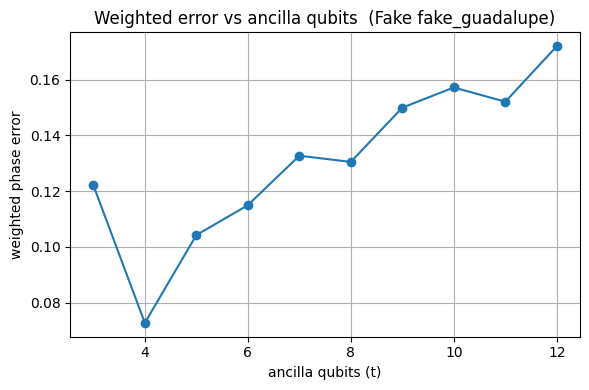

In [ ]:
import inspect, numpy as np, matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, noise
from qiskit_ibm_runtime import fake_provider

phi, t_ancilla, n_target, SHOTS = 3/7, 12, 1, 4096
qubits_req = t_ancilla + n_target

def pick_fake_backend(min_qubits: int):
    candidates = []
    for name, cls in inspect.getmembers(fake_provider, inspect.isclass):
        if not (name.startswith("Fake") and name.endswith("V2")):
            continue
        try:
            backend = cls()
        except Exception:
            continue
        if hasattr(backend, "num_qubits") and backend.num_qubits >= min_qubits:
            candidates.append((backend.num_qubits, backend))
    if not candidates:
        raise RuntimeError(f"{min_qubits}-qubit 이상 지원하는 fake backend가 없습니다.")
    return sorted(candidates, key=lambda x: x[0])[1][1]
    
fake_backend = pick_fake_backend(qubits_req)
print(f"◎ Fake backend = {fake_backend.name}  ({fake_backend.num_qubits} qubits)")

backend_noise = noise.NoiseModel.from_backend(fake_backend)
simulator = AerSimulator(
    noise_model = backend_noise,
    basis_gates = backend_noise.basis_gates,
    coupling_map= fake_backend.configuration().coupling_map
)

U_gate, state_prep = make_U_phi(phi), QuantumCircuit(1); state_prep.x(0)
qpe_circ = create_qpe_circuit(t_ancilla, U_gate, state_prep)

t_qc = transpile(
    qpe_circ,
    target            = fake_backend.target,    
    optimization_level= 3,
    seed_transpiler   = 42
)

result = simulator.run(t_qc, shots=SHOTS).result()
counts = result.get_counts()
w_err  = sum(abs(int(b,2)/(2**t_ancilla)-phi)*c for b,c in counts.items()) / SHOTS
print(f"⇒ weighted error = {w_err:.3e}")

t_range, errs = [], []
for t in range(3, 13):
    if t + n_target > fake_backend.num_qubits:
        continue
    qc  = create_qpe_circuit(t, U_gate, state_prep)
    tqc = transpile(qc, target=fake_backend.target,
                    optimization_level=3, seed_transpiler=42)
    cnts = simulator.run(tqc, shots=SHOTS).result().get_counts()
    err  = sum(abs(int(b,2)/(2**t)-phi)*c for b,c in cnts.items()) / SHOTS
    t_range.append(t); errs.append(err)

if t_range:
    plt.figure(figsize=(6,4))
    plt.plot(t_range, errs, marker='o')
    plt.title(f"Weighted error vs ancilla qubits  (Fake {fake_backend.name})")
    plt.xlabel("ancilla qubits (t)")
    plt.ylabel("weighted phase error")
    plt.grid(True); plt.tight_layout();
    plt.show()


C:\Users\yoonh\AppData\Local\Temp\ipykernel_9584\1639960316.py:32: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(num_ancilla, do_swaps=True).inverse(),


t= 3, depolarizing    → weighted error = 1.223e-01
t= 3, phase_damping   → weighted error = 1.019e-01
t= 3, amplitude_damping → weighted error = 1.062e-01
t= 3, readout         → weighted error = 9.893e-02
t= 4, depolarizing    → weighted error = 8.032e-02
t= 4, phase_damping   → weighted error = 3.287e-02
t= 4, amplitude_damping → weighted error = 4.590e-02
t= 4, readout         → weighted error = 2.529e-02
t= 5, depolarizing    → weighted error = 9.503e-02
t= 5, phase_damping   → weighted error = 4.363e-02
t= 5, amplitude_damping → weighted error = 5.478e-02
t= 5, readout         → weighted error = 3.046e-02
t= 6, depolarizing    → weighted error = 1.056e-01
t= 6, phase_damping   → weighted error = 4.046e-02
t= 6, amplitude_damping → weighted error = 5.219e-02
t= 6, readout         → weighted error = 2.753e-02
t= 7, depolarizing    → weighted error = 1.090e-01
t= 7, phase_damping   → weighted error = 3.475e-02
t= 7, amplitude_damping → weighted error = 4.945e-02
t= 7, readout        

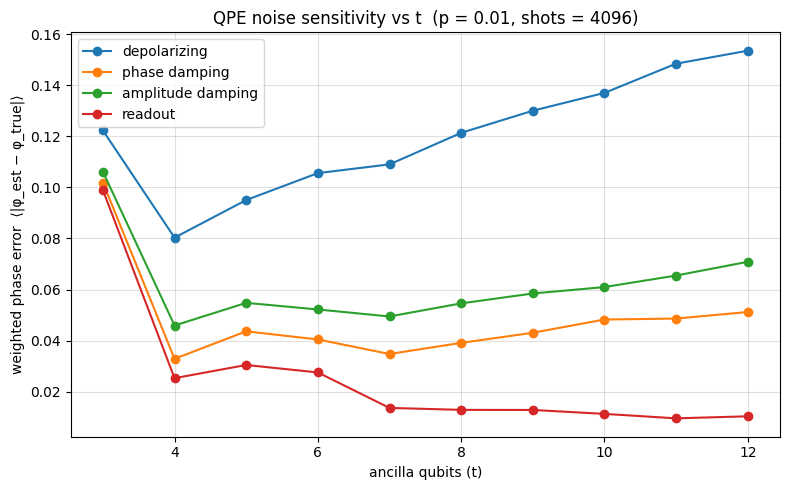

In [ ]:
import numpy as np, matplotlib.pyplot as plt

phi        = 3/7
SHOTS      = 4096
p_fixed    = 0.01
noise_kinds = [               
               "depolarizing",
               "phase_damping", "amplitude_damping",
               "readout"]

U_gate      = make_U_phi(phi)
state_prep  = QuantumCircuit(1); state_prep.x(0)


t_values = range(3, 13)       


results = {k: [] for k in noise_kinds}   

for t in t_values:
    for kind in noise_kinds:
        nm = None if kind == "ideal" else make_noise_model(kind, p_fixed)
        w_err, _ = run_qpe_weighted_error(
            num_ancilla = t,
            U_gate      = U_gate,
            state_prep  = state_prep,
            true_phi    = phi,
            noise_model = nm,
            shots       = SHOTS
        )
        results[kind].append(w_err)
        print(f"t={t:2d}, {kind:15s} → weighted error = {w_err:.3e}")

plt.figure(figsize=(8,5))
for kind, errs in results.items():
    style = '-' if kind != "ideal" else '--'
    plt.plot(list(t_values), errs, marker='o', linestyle=style,
             label=kind.replace('_',' '))
plt.xlabel("ancilla qubits (t)")
plt.ylabel("weighted phase error  ⟨|φ_est − φ_true|⟩")
plt.title(f"QPE noise sensitivity vs t  (p = {p_fixed}, shots = {SHOTS})")
plt.legend()
plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService                                 
try:                                   
    from qiskit_ibm_runtime import SamplerV2 as Sampler
except ImportError: 
    from qiskit_ibm_runtime import Sampler

phi, t_ancilla, n_target, SHOTS = 3/7, 12, 1, 4096
qubits_req = t_ancilla + n_target


service  = QiskitRuntimeService()                                         
backend  = service.least_busy(simulator=False, operational=True) 
print(f"Real backend = {backend.name}  ({backend.num_qubits} qubits)")

U_gate, state_prep = make_U_phi(phi), QuantumCircuit(1); state_prep.x(0)
qpe_circ = create_qpe_circuit(t_ancilla, U_gate, state_prep)

pm   = generate_preset_pass_manager(backend=backend, optimization_level=3)
t_qc = pm.run(qpe_circ)


sampler = Sampler(backend)                                     
job     = sampler.run([t_qc], shots=SHOTS)
pub     = job.result()[0]


counts = pub.join_data().get_counts() 


w_err = sum(abs(int(b, 2)/(2**t_ancilla) - phi) * c
            for b, c in counts.items()) / SHOTS
print(f"⇒ weighted error = {w_err:.3e}")

t_range, errs = [], []
for t in range(3, 13):
    if t + n_target > backend.num_qubits:
        continue
    qc  = create_qpe_circuit(t, U_gate, state_prep)
    tqc = generate_preset_pass_manager(
            backend=backend, optimization_level=3).run(qc)

    qsamp = Sampler(backend)
    qjob  = qsamp.run([tqc], shots=SHOTS)
    pub   = qsamp.run([tqc], shots=SHOTS).result()[0]
    cnts  = pub.join_data().get_counts()

    err = sum(abs(int(b, 2)/(2**t) - phi) * c for b, c in cnts.items()) / SHOTS
    t_range.append(t); errs.append(err)

if t_range:
    plt.figure(figsize=(6,4))
    plt.plot(t_range, errs, marker='o')
    plt.title(f"Weighted error vs ancilla qubits  ({backend.name})")
    plt.xlabel("ancilla qubits (t)")
    plt.ylabel("weighted phase error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Real backend = ibm_strasbourg  (127 qubits)


C:\Users\82108\AppData\Local\Temp\ipykernel_39344\1639960316.py:32: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(num_ancilla, do_swaps=True).inverse(),
